# Wine Classification
## Dataset preparation
### Data loading and preprocessing

In [1]:
from typing import Any
import torch
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def load_processed_data(X, y, ratio=0.3):
    """
    Process wine dataset for neural network training.

    Args:
        X: Feature matrix from wine dataset
        y: Target labels from wine dataset
        ratio: Test set size ratio (default: 0.3)

    Returns:
        Tuple of tensors: (X_train, X_test, y_train, y_test)
    """
    # Split data with stratification to maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=ratio, stratify=y
    )

    # Standardize features for better neural network training
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors with appropriate dtypes
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor


# Load wine classification dataset (3 classes, 13 features)
wine: Any = load_wine()
X_train, X_test, y_train, y_test = load_processed_data(
    wine.data, wine.target, ratio=0.3
)

# Display sample of preprocessed training data
print(f"Training X size: {X_train.size()}")
print(f"Validation X size: {X_test.size()}")

Training X size: torch.Size([124, 13])
Validation X size: torch.Size([54, 13])


## Neural network training
### Neural network architecture and training

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Define neural network architecture: 13 -> 8 -> 8 -> 3
model = nn.Sequential(
    nn.Linear(13, 8), nn.ReLU(), nn.Linear(8, 8), nn.ReLU(), nn.Linear(8, 3), nn.ReLU()
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_network(
    model,
    criterion,
    optimizer,
    X_train,
    X_test,
    y_train,
    y_test,
    epochs=500,
    report_epochs=100,
):
    """
    Train neural network with validation tracking and progress reporting.

    Args:
        model: PyTorch neural network model
        criterion: Loss function (e.g., CrossEntropyLoss)
        optimizer: Optimization algorithm (e.g., Adam)
        X_train, X_test: Training and test feature tensors
        y_train, y_test: Training and test label tensors
        epochs: Number of training epochs (default: 500)
        report_epochs: Frequency of progress reporting (default: 100)

    Returns:
        dict: Training history with loss, validation loss, and accuracy scores
    """
    history = {"loss": [], "val_loss": [], "accuracy_score": []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        history["loss"].append(loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_output = model(X_test)
            val_loss = criterion(val_output, y_test)
            history["val_loss"].append(val_loss.item())

            # Convert logits to predicted classes
            predictions = torch.argmax(outputs, dim=1)
            val_predictions = torch.argmax(val_output, dim=1)

            # Alternative using max:
            # _, predictions = torch.max(outputs, dim=1)
            # _, val_predictions = torch.max(val_output, dim=1)

            acc_score = accuracy_score(y_train.numpy(), predictions.numpy())
            val_acc_score = accuracy_score(y_test.numpy(), val_predictions.numpy())
            history["accuracy_score"].append((acc_score, val_acc_score))

        if not (epoch + 1) % report_epochs:
            print(
                f"Epoch: {epoch + 1} Loss: {loss}, Validation loss: {val_loss}\nTraining accuracy score: {acc_score}, Validation accuracy score: {val_acc_score}\n"
            )

    return history

### Model training execution

In [3]:
# Execute training
history = train_network(
    model,
    criterion,
    optimizer,
    X_train,
    X_test,
    y_train,
    y_test,
    epochs=1000,
    report_epochs=200,
)

Epoch: 200 Loss: 0.43433883786201477, Validation loss: 0.4850600063800812
Training accuracy score: 0.9435483870967742, Validation accuracy score: 0.9074074074074074

Epoch: 400 Loss: 0.03294513747096062, Validation loss: 0.09403987228870392
Training accuracy score: 1.0, Validation accuracy score: 0.9814814814814815

Epoch: 600 Loss: 0.008913095109164715, Validation loss: 0.08469848334789276
Training accuracy score: 1.0, Validation accuracy score: 0.9814814814814815

Epoch: 800 Loss: 0.003976415377110243, Validation loss: 0.09035199135541916
Training accuracy score: 1.0, Validation accuracy score: 0.9814814814814815

Epoch: 1000 Loss: 0.002209871541708708, Validation loss: 0.09441785514354706
Training accuracy score: 1.0, Validation accuracy score: 0.9814814814814815



### Model training histogram

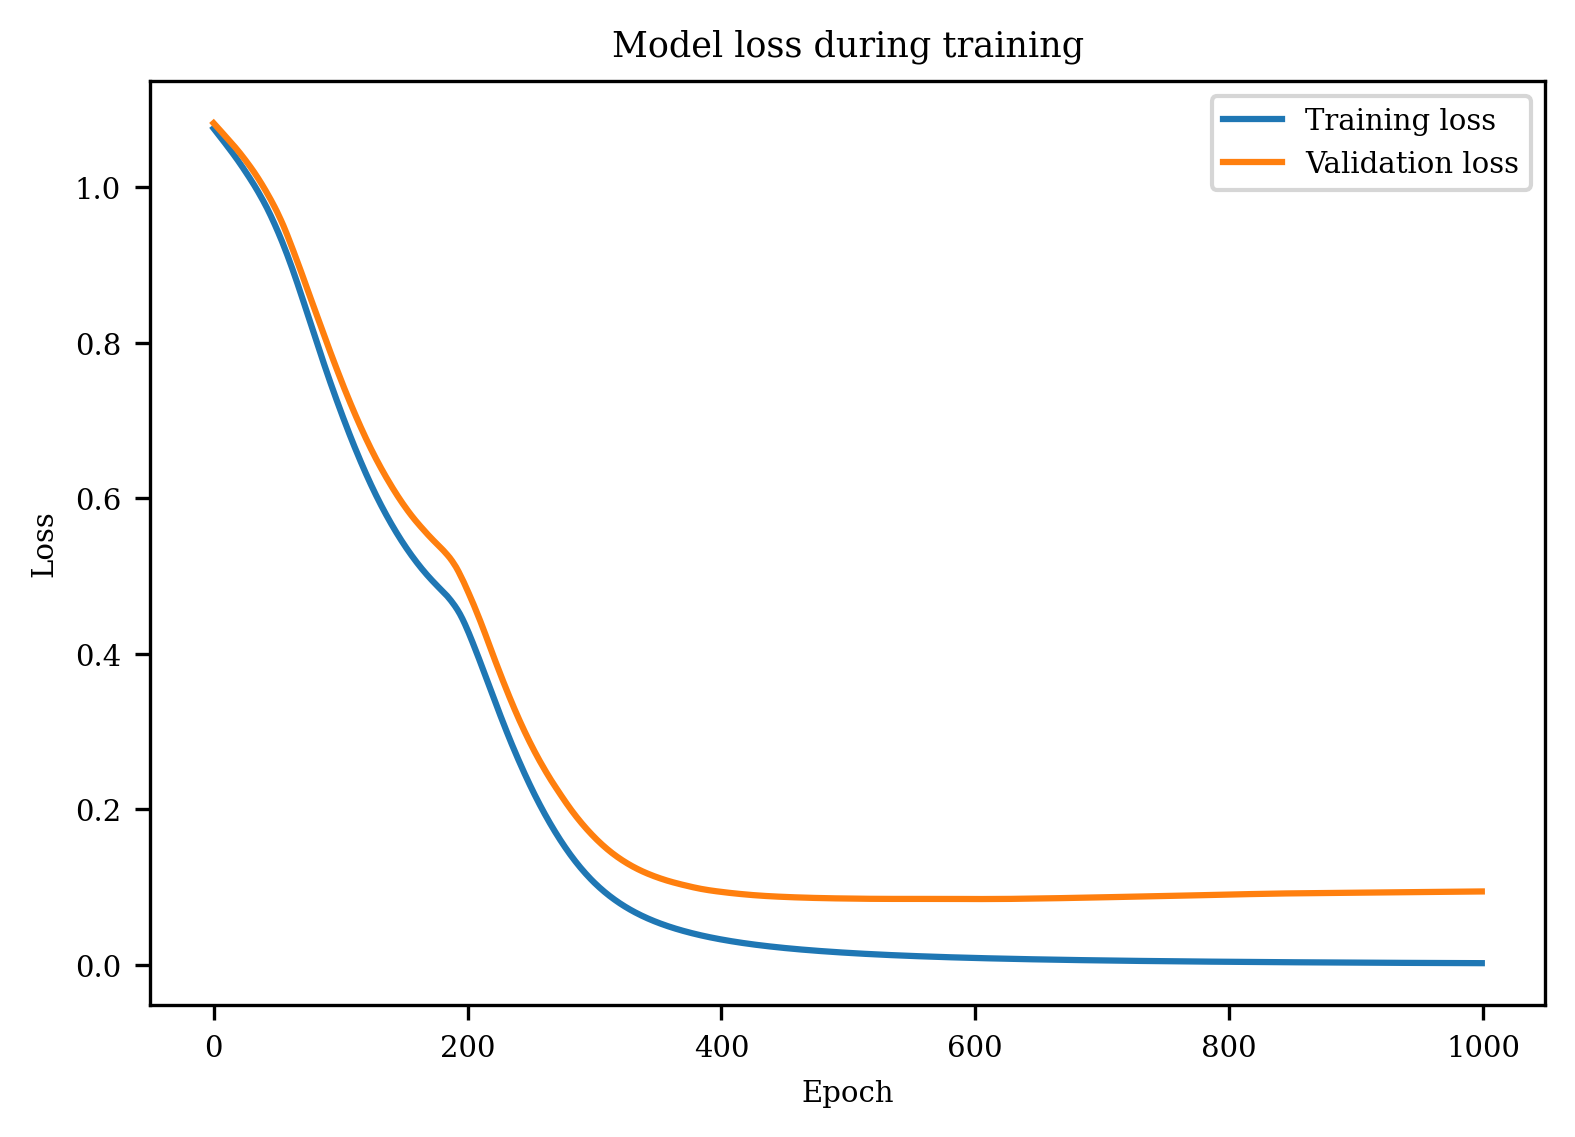

In [4]:
import matplotlib.pyplot as plt

# Extract training metrics for visualization
num_epochs = range(len(history["loss"]))
train_loss, validation_loss = history["loss"], history["val_loss"]

# Configure matplotlib for high-quality plots
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 7
plt.rcParams["figure.dpi"] = 300

plt.figure(figsize=(6, 4))
plt.plot(num_epochs, train_loss, label="Training loss")
plt.plot(num_epochs, validation_loss, label="Validation loss")
plt.title("Model loss during training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Model persistence
### Saving a model

In [5]:
import os
import torch

# Create models directory if it doesn't exist
os.makedirs("./models", exist_ok=True)

# Save entire model (architecture + weights) to file
torch.save(model, "./models/wine_classification.pth")

### Loading a model

In [6]:
import torch
from sklearn.metrics import accuracy_score

# Load the saved model from file
loaded_model = torch.load("./models/wine_classification.pth", weights_only=False)

# Set model to evaluation mode for inference
loaded_model.eval()
with torch.no_grad():
    # Generate predictions on test set
    loaded_outputs = loaded_model(X_test)
    loaded_predictions = torch.argmax(loaded_outputs, dim=1)

    # Calculate accuracy score for loaded model
    loaded_accuracy = accuracy_score(y_test, loaded_predictions)

print(f"Loaded model's accuracy score = {loaded_accuracy}")

Loaded model's accuracy score = 0.9814814814814815
